<a href="https://colab.research.google.com/github/ttlttk8161/-PBL-Reinforcement-learning/blob/main/2_dynimic_programing_share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install koreanize-matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 57.0 MB/s eta 0:00:00


In [4]:
# koreanize-matplotlib으로 한글 폰트 설정
import matplotlib.pyplot as plt
import koreanize_matplotlib
import numpy as np


In [5]:
class GridWorld:
    def __init__(self, size=3):
        self.size = size
        self.states = [(i, j) for i in range(size) for j in range(size)]
        self.actions = ['up', 'down', 'left', 'right']
        self.terminal_states = [(0, 0), (size-1, size-1)]  # 시작점과 목표점을 터미널 상태로 설정
        self.rewards = {}  # 터미널 상태가 아닌 모든 상태에서 -1의 보상

    def get_next_state(self, state, action):
        """주어진 상태에서 행동을 취했을 때의 다음 상태를 반환"""
        row, col = state

        if action == 'up':
            next_state = (max(0, row - 1), col)
        elif action == 'down':
            next_state = (min(self.size - 1, row + 1), col)
        elif action == 'left':
            next_state = (row, max(0, col - 1))
        elif action == 'right':
            next_state = (row, min(self.size - 1, col + 1))
        else:
            next_state = state

        return next_state

    def get_transition_probability(self, state, action, next_state):
        """상태 전이 확률을 반환 (결정적 환경이므로 1.0 또는 0.0)"""
        if self.is_terminal(state):
            # 터미널 상태에서는 자기 자신으로 전이
            return 1.0 if next_state == state else 0.0

        expected_next_state = self.get_next_state(state, action)
        return 1.0 if next_state == expected_next_state else 0.0

    def get_reward(self, state, action, next_state):
        """상태 전이에 대한 보상을 반환"""
        if self.is_terminal(next_state):
            return 0.0
        return -1.0

    def is_terminal(self, state):
        """터미널 상태인지 확인"""
        return state in self.terminal_states

    def get_possible_next_states(self, state, action):
        """주어진 상태와 행동에서 가능한 모든 다음 상태들을 반환"""
        if self.is_terminal(state):
            return [state]  # 터미널 상태에서는 자기 자신만 반환
        return [self.get_next_state(state, action)]

---
# 정책 평가

In [50]:
# V = {grid_world.states: 0}
# grid_world.states
# V = { 0 for s in grid_world.states }
# policy = {s: {a: 0.25 for a in grid_world.actions} for s in grid_world.states}
V = { s: 0 for s in grid_world.states }
V

{(0, 0): 0,
 (0, 1): 0,
 (0, 2): 0,
 (1, 0): 0,
 (1, 1): 0,
 (1, 2): 0,
 (2, 0): 0,
 (2, 1): 0,
 (2, 2): 0}

정책 평가 시작...
반복 10: Δ = 0.067433
반복 20: Δ = 0.002087
반복 29: Δ = 0.000091
수렴 완료! 총 29번 반복

=== 최종 상태 가치 함수 ===
V(0,0) = 0.0000  V(0,1) = -3.5633  V(0,2) = -4.7335  
V(1,0) = -3.5633  V(1,1) = -4.2070  V(1,2) = -3.5634  
V(2,0) = -4.7335  V(2,1) = -3.5634  V(2,2) = 0.0000  


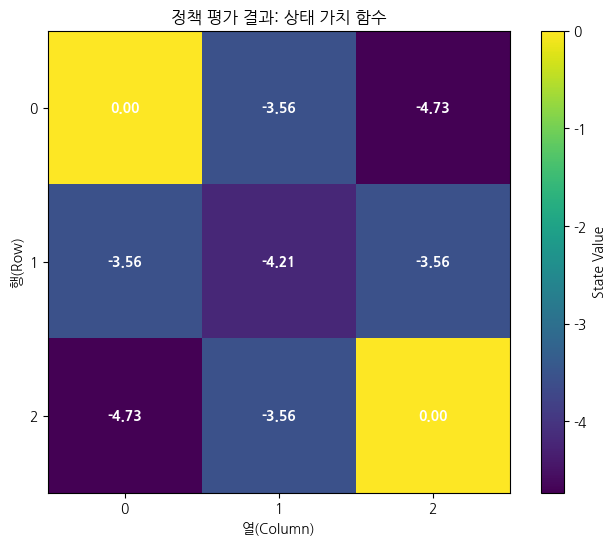

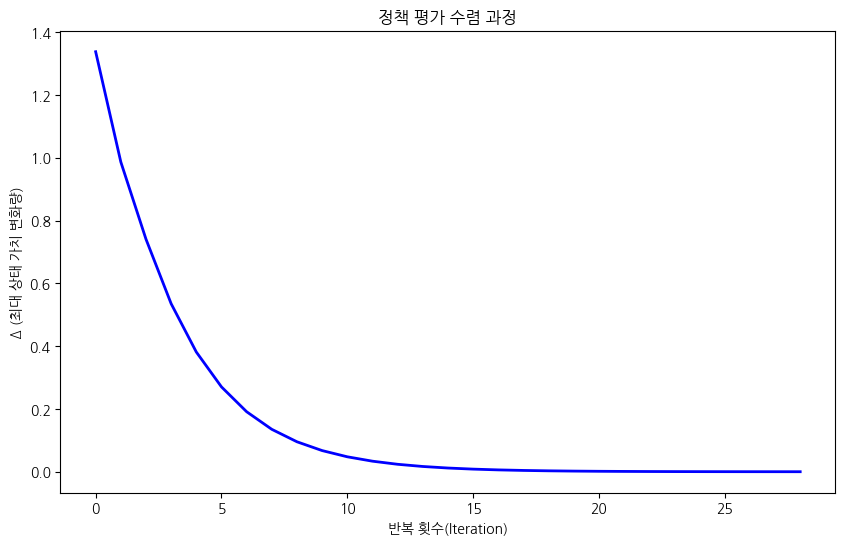

In [54]:
from os import stat
# 정책 평가 알고리즘 구현
# 1. 모든 상태 s에 대해 V(s) = 0으로 초기화
# 2. 반복:
#    a. Δ = 0
#    b. 모든 상태 s에 대해:
#       i. v = V(s)
#       ii. V(s) = Σ_a π(a|s) Σ_s' P(s'|s,a)[R(s,a,s') + γV(s')]
#       iii. Δ = max(Δ, |v - V(s)|)
#    c. Δ < θ(작은 임계값)이면 종료

import numpy as np
import matplotlib.pyplot as plt

# 위에서 정의한 GridWorld 클래스 사용
grid_world = GridWorld(size=3)
gamma = 0.9
theta = 1e-4

# 초기 정책: 모든 상태에서 모든 행동을 동일 확률로 선택
policy = {s: {a: 0.25 for a in grid_world.actions} for s in grid_world.states}

def policy_evaluation_algorithm(grid_world, policy, gamma=0.9, theta=1e-4):
    """
    정책 평가 알고리즘을 구현하는 함수

    Args:
        grid_world: 그리드 환경
        policy: 평가할 정책 (딕셔너리 형태)
        gamma: 할인 인수
        theta: 수렴 임계값

    Returns:
        V: 상태 가치 함수
        deltas: 각 반복에서의 delta 값들
    """
    # 1. 모든 상태 s에 대해 V(s) = 0으로 초기화
    V = { s: 0 for s in grid_world.states } # [TODO] 모든 상태를 키로 하고 초기값 0을 갖는 딕셔너리를 만드세요
    deltas = []
    iteration = 0

    print("정책 평가 시작...")

    while True:
        iteration += 1
        # 2a. Δ = 0
        delta = 0  # [TODO] 델타 값을 0으로 초기화하세요

        # 2b. 모든 상태 s에 대해
        for s in grid_world.states:
            # 터미널 상태는 건너뛰기
            if grid_world.is_terminal(s):
                continue

            # 2b-i. v = V(s) (이전 상태 가치 저장)
            v = V[s]  # [TODO] 현재 상태 s의 가치 V[s]를 저장하세요

            # 2b-ii. V(s) = Σ_a π(a|s) Σ_s' P(s'|s,a)[R(s,a,s') + γV(s')]
            # 벨만 기댓값 방정식을 사용하여 새로운 상태 가치 계산
            v_new = 0
            for a in grid_world.actions:
                # 행동 a를 취했을 때의 다음 상태와 보상 계산
                next_state = grid_world.get_next_state(s, a)
                reward = grid_world.get_reward(s, a, next_state)  # [TODO] get_reward 메서드를 사용해 보상을 계산하세요
                # π(a|s) * [R(s,a,s') + γV(s')]
                v_new += policy[s][a] * (reward + gamma * V[next_state])  # [TODO] 할인인자 gamma를 곱하세요

            V[s] = v_new  # [TODO] 상태 s의 새로운 가치를 v_new로 업데이트하세요

            # 2b-iii. Δ = max(Δ, |v - V(s)|)
            delta = max(delta, abs(v - V[s]))  # [TODO] V[s]를 넣어 이전 값과 새 값의 차이를 계산하세요

        deltas.append(delta)

        # 진행 상황 출력
        if iteration % 10 == 0 or delta < theta:
            print(f"반복 {iteration}: Δ = {delta:.6f}")

        # 2c. Δ < θ(작은 임계값)이면 종료
        if delta < theta:  # [TODO] 수렴 기준 theta보다 작으면 종료하도록 조건을 완성하세요
            print(f"수렴 완료! 총 {iteration}번 반복")
            break

    return V, deltas

# 정책 평가 실행
final_V, convergence_deltas = policy_evaluation_algorithm(grid_world, policy, gamma, theta)

# 결과 시각화 함수
def visualize_value_function(grid_world, V):
    """상태 가치 함수를 격자로 시각화"""
    value_grid = np.zeros((grid_world.size, grid_world.size))
    for i in range(grid_world.size):
        for j in range(grid_world.size):
            value_grid[i, j] = V.get((i, j), 0)

    plt.figure(figsize=(8, 6))
    plt.imshow(value_grid, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='State Value')

    # 각 셀에 값 표시
    for i in range(grid_world.size):
        for j in range(grid_world.size):
            plt.text(j, i, f'{value_grid[i, j]:.2f}',
                    ha='center', va='center', color='white', fontweight='bold')

    plt.title('정책 평가 결과: 상태 가치 함수')
    plt.xlabel('열(Column)')
    plt.ylabel('행(Row)')
    plt.xticks(range(grid_world.size))
    plt.yticks(range(grid_world.size))
    plt.show()

def plot_convergence(deltas):
    """수렴 과정 시각화"""
    plt.figure(figsize=(10, 6))
    plt.plot(deltas, 'b', linewidth=2)
    plt.xlabel('반복 횟수(Iteration)')
    plt.ylabel('Δ (최대 상태 가치 변화량)')
    plt.title('정책 평가 수렴 과정')
    plt.show()

# 결과 출력
print("\n=== 최종 상태 가치 함수 ===")
for i in range(grid_world.size):
    for j in range(grid_world.size):
        print(f"V({i},{j}) = {final_V.get((i,j), 0):.4f}", end="  ")
    print()

# 시각화
visualize_value_function(grid_world, final_V)
plot_convergence(convergence_deltas)


---

# 정책 개선

정책 반복 알고리즘을 실행합니다...
=== 정책 반복 알고리즘 시작 ===

--- 반복 1 ---
정책 평가 수행 중...
정책 개선 수행 중...
현재 정책:
T  ←  →  ↑  
↑  ↑  →  ↓  
↓  ↓  →  ↓  
↓  ←  →  T  

--- 반복 2 ---
정책 평가 수행 중...
정책 개선 수행 중...
현재 정책:
T  ←  ←  ↓  
↑  ↑  ↓  ↓  
↑  ↑  ↓  ↓  
↑  →  →  T  

--- 반복 3 ---
정책 평가 수행 중...
정책 평가가 3번 반복 후 수렴했습니다.
정책 개선 수행 중...
현재 정책:
T  ←  ←  ↓  
↑  ↑  ↑  ↓  
↑  ↑  ↓  ↓  
↑  →  →  T  

--- 반복 4 ---
정책 평가 수행 중...
정책 평가가 3번 반복 후 수렴했습니다.
정책 개선 수행 중...
정책이 수렴했습니다! (반복 횟수: 4)

=== 최적 정책 (총 4번 반복) ===
T  ←  ←  ↓  
↑  ↑  ↑  ↓  
↑  ↑  ↓  ↓  
↑  →  →  T  

=== 최적 상태 가치 함수 ===
V*(0,0) = 0.0000  V*(0,1) = 0.0000  V*(0,2) = -1.0000  V*(0,3) = -2.0000  
V*(1,0) = 0.0000  V*(1,1) = -1.0000  V*(1,2) = -2.0000  V*(1,3) = -1.0000  
V*(2,0) = -1.0000  V*(2,1) = -2.0000  V*(2,2) = -1.0000  V*(2,3) = 0.0000  
V*(3,0) = -2.0000  V*(3,1) = -1.0000  V*(3,2) = 0.0000  V*(3,3) = 0.0000  

=== 통합 시각화: 최적 정책과 상태 가치 함수 ===


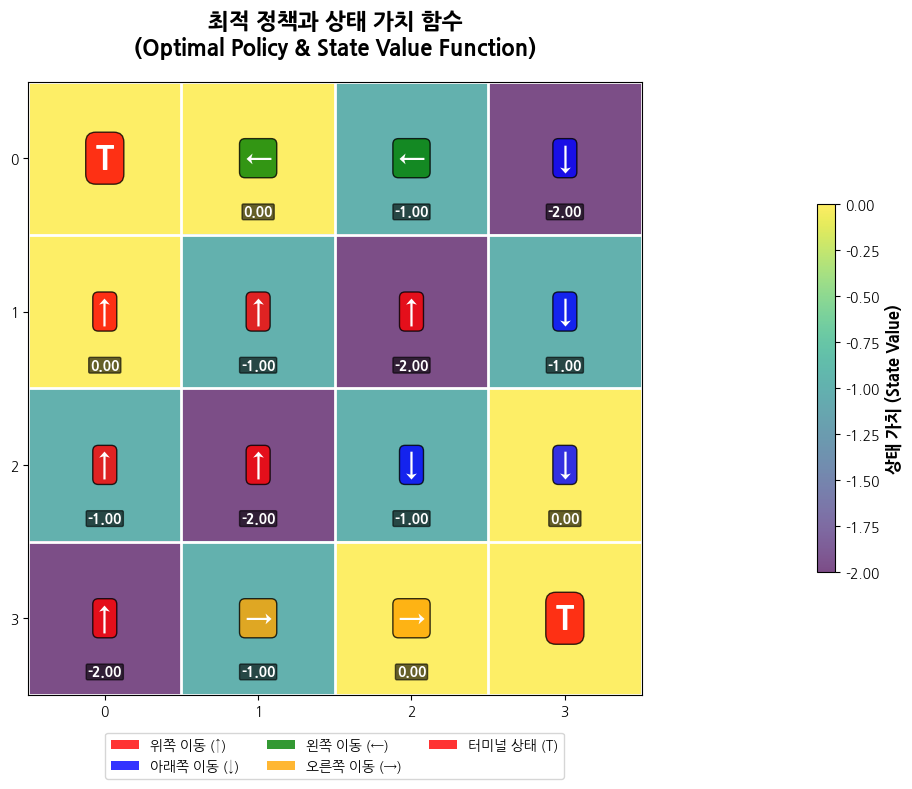

In [ ]:
# 이전에 정의된 GridWorld 환경 사용
grid_size = 4
env = GridWorld(grid_size)

def policy_improvement(env, policy, V, gamma=1.0):
    """
    정책 개선 알고리즘
    현재 정책을 기반으로 더 나은 정책을 찾는다

    Args:
        env: 환경 (GridWorld)
        policy: 현재 정책 (dict)
        V: 현재 상태 가치 함수 (dict)
        gamma: 할인 인자

    Returns:
        new_policy: 개선된 정책 (dict)
        policy_stable: 정책이 안정화되었는지 여부 (bool)
    """
    new_policy = {}
    policy_stable = True

    # 모든 상태에 대해 정책 개선 수행
    for state in env.states:
        # 현재 정책에서의 행동
        old_action = policy[state]

        # [TODO] 각 행동에 대한 기댓값(Q값) 계산하기
        # action_values 딕셔너리를 만들어서 각 action의 가치를 저장해야 함
        action_values = {}
        for action in env.actions:
            # [TODO] Bellman 방정식을 사용하여 Q(s,a) 계산
            # Q(s,a) = R(s,a,s') + γV(s')
            next_state = env.get_next_state(state, action)
            reward = env.get_reward(state, action, next_state)
            action_value = ____  # reward + gamma * V의 다음 상태 값
            action_values[action] = action_value

        # [TODO] 최대 가치를 가지는 행동 선택 (argmax 연산)
        best_action = ____  # action_values에서 최대값을 가지는 키 찾기
        new_policy[state] = best_action

        # 정책이 변경되었는지 확인
        if old_action != best_action:
            policy_stable = False

    return new_policy, policy_stable

def policy_iteration(env, gamma=1.0, theta=1e-6, max_iterations=100):
    """
    정책 반복 알고리즘
    정책 평가와 정책 개선을 반복하여 최적 정책을 찾는다

    Args:
        env: 환경 (GridWorld)
        gamma: 할인 인자
        theta: 수렴 임계값
        max_iterations: 최대 반복 횟수

    Returns:
        policy: 최적 정책 (dict)
        V: 최적 상태 가치 함수 (dict)
        iteration_count: 총 반복 횟수
    """
    # 1. 초기 정책을 무작위로 설정
    policy = {}
    for state in env.states:
        policy[state] = np.random.choice(env.actions)

    iteration_count = 0
    policy_history = []  # 정책 변화 기록

    print("=== 정책 반복 알고리즘 시작 ===")

    for iteration in range(max_iterations):
        print(f"\n--- 반복 {iteration + 1} ---")

        # [TODO] 정책 평가: 현재 정책에 대해 상태 가치 함수 계산
        print("정책 평가 수행 중...")
        V, _ = ____  # policy_evaluation 함수 호출

        # [TODO] 정책 개선: 새로운 정책 계산
        print("정책 개선 수행 중...")
        new_policy, policy_stable = ____  # policy_improvement 함수 호출

        # 정책 변화 기록
        policy_history.append(policy.copy())

        # [TODO] 정책이 안정화되었는지 확인하고 수렴 조건 체크
        if ____:  # policy_stable이 True인지 확인
            print(f"정책이 수렴했습니다! (반복 횟수: {iteration + 1})")
            break

        # 정책 업데이트
        policy = new_policy
        iteration_count = iteration + 1

        # 현재 정책 출력
        print("현재 정책:")
        print_policy(policy)

    else:
        print(f"최대 반복 횟수({max_iterations})에 도달했습니다.")

    return policy, V, iteration_count + 1, policy_history

def policy_evaluation(env, policy, gamma=1.0, theta=1e-6, max_iterations=1000):
    """
    정책 평가 알고리즘
    주어진 정책에 대해 상태 가치 함수를 계산한다

    Args:
        env: 환경 (GridWorld)
        policy: 평가할 정책 (dict)
        gamma: 할인 인자
        theta: 수렴 임계값
        max_iterations: 최대 반복 횟수

    Returns:
        V: 상태 가치 함수 (dict)
        deltas: 수렴 과정 (list)
    """
    # [TODO] 상태 가치 함수 초기화 (모든 상태를 0.0으로)
    V = {}
    for state in env.states:
        V[state] = ____  # 0.0으로 초기화

    deltas = []

    for iteration in range(max_iterations):
        delta = 0
        # 모든 상태에 대해 업데이트
        for state in env.states:
            v = V[state]

            # [TODO] 현재 정책에 따른 행동 가져오기
            action = ____  # policy에서 현재 state의 action 가져오기

            # [TODO] 다음 상태와 보상 계산
            next_state = ____  # env.get_next_state 함수 사용
            reward = ____  # env.get_reward 함수 사용

            # [TODO] Bellman 방정식 적용
            # V(s) = R(s,a,s') + γV(s')
            V[state] = ____  # reward + gamma * V[next_state]

            # 변화량 계산
            delta = max(delta, abs(v - V[state]))

        deltas.append(delta)

        # [TODO] 수렴 확인 (delta가 theta보다 작은지)
        if ____:  # delta < theta 조건
            print(f"정책 평가가 {iteration + 1}번 반복 후 수렴했습니다.")
            break

    return V, deltas

def print_policy(policy, grid_size=4):
    """정책을 그리드 형태로 출력"""
    action_symbols = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}

    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) == (0, 0) or (i, j) == (grid_size-1, grid_size-1):
                print("T", end="  ")  # Terminal state
            else:
                action = policy[(i, j)]
                print(action_symbols[action], end="  ")
        print()

def visualize_policy_and_value(policy, V, grid_size=4):
    """정책과 가치 함수를 하나의 그래프에서 시각화"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # 가치 함수를 그리드 형태로 변환
    value_grid = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) in V:
                value_grid[i, j] = V[(i, j)]

    # 가치 함수를 배경으로 표시
    im = ax.imshow(value_grid, cmap='viridis', interpolation='nearest', alpha=0.7)

    # 컬러바 추가 (오른쪽 공간 확보)
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, pad=0.15)
    cbar.set_label('상태 가치 (State Value)', fontsize=12, fontweight='bold')

    # 화살표로 정책 표시
    action_symbols = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}
    action_colors = {'up': 'red', 'down': 'blue', 'left': 'green', 'right': 'orange'}

    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) == (0, 0) or (i, j) == (grid_size-1, grid_size-1):
                # 터미널 상태 표시
                ax.text(j, i, 'T', ha='center', va='center',
                       fontsize=24, fontweight='bold', color='white',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.8))
            elif (i, j) in policy:
                action = policy[(i, j)]
                # 정책 화살표 표시
                ax.text(j, i, action_symbols[action], ha='center', va='center',
                       fontsize=20, fontweight='bold', color='white',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor=action_colors[action], alpha=0.8))

                # 가치 함수 값 표시 (화살표 아래)
                ax.text(j, i+0.35, f'{value_grid[i, j]:.2f}', ha='center', va='center',
                       fontsize=10, fontweight='bold', color='white',
                       bbox=dict(boxstyle="round,pad=0.1", facecolor='black', alpha=0.6))

    # 그리드 선 추가
    for i in range(grid_size + 1):
        ax.axhline(i - 0.5, color='white', linewidth=2)
        ax.axvline(i - 0.5, color='white', linewidth=2)

    ax.set_title('최적 정책과 상태 가치 함수\n(Optimal Policy & State Value Function)',
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))

    # 범례 추가 (그래프 아래쪽에 배치하여 겹치지 않도록)
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.8, label='위쪽 이동 (↑)'),
        plt.Rectangle((0,0),1,1, facecolor='blue', alpha=0.8, label='아래쪽 이동 (↓)'),
        plt.Rectangle((0,0),1,1, facecolor='green', alpha=0.8, label='왼쪽 이동 (←)'),
        plt.Rectangle((0,0),1,1, facecolor='orange', alpha=0.8, label='오른쪽 이동 (→)'),
        plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.8, label='터미널 상태 (T)')
    ]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05),
              ncol=3, fontsize=10, frameon=True)

    plt.tight_layout()
    plt.show()

def visualize_policy(policy, grid_size=4):
    """정책을 시각화"""
    plt.figure(figsize=(8, 8))

    # 행동을 숫자로 매핑 (시각화용)
    action_to_num = {'up': 0, 'right': 1, 'down': 2, 'left': 3}
    policy_grid = np.zeros((grid_size, grid_size))

    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) in policy:
                policy_grid[i, j] = action_to_num[policy[(i, j)]]

    plt.imshow(policy_grid, cmap='Set3', interpolation='nearest')

    # 화살표로 정책 표시
    action_symbols = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) == (0, 0) or (i, j) == (grid_size-1, grid_size-1):
                plt.text(j, i, 'T', ha='center', va='center',
                        fontsize=20, fontweight='bold', color='red')
            elif (i, j) in policy:
                action = policy[(i, j)]
                plt.text(j, i, action_symbols[action], ha='center', va='center',
                        fontsize=20, fontweight='bold', color='black')

    plt.title('Optimal Policy (최적 정책)')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.xticks(range(grid_size))
    plt.yticks(range(grid_size))
    plt.grid(True, alpha=0.3)
    plt.show()

def visualize_value_function(V, grid_size=4):
    """상태 가치 함수를 시각화"""
    plt.figure(figsize=(8, 6))

    # 가치 함수를 그리드 형태로 변환
    value_grid = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) in V:
                value_grid[i, j] = V[(i, j)]

    plt.imshow(value_grid, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='State Value')

    # 각 셀에 값 표시
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f'{value_grid[i, j]:.2f}',
                    ha='center', va='center', color='white', fontweight='bold')

    plt.title('Optimal State Value Function (최적 상태 가치 함수)')
    plt.xticks(range(grid_size))
    plt.yticks(range(grid_size))
    plt.show()

# [TODO] 정책 반복 알고리즘 실행하기
print("정책 반복 알고리즘을 실행합니다...")
optimal_policy, optimal_V, iterations, policy_hist = ____  # policy_iteration 함수 호출 (gamma=1.0, theta=1e-6)

print(f"\n=== 최적 정책 (총 {iterations}번 반복) ===")
print_policy(optimal_policy)

print("\n=== 최적 상태 가치 함수 ===")
for i in range(grid_size):
    for j in range(grid_size):
        if (i, j) in optimal_V:
            print(f"V*({i},{j}) = {optimal_V[(i,j)]:.4f}", end="  ")
        else:
            print(f"V*({i},{j}) = 0.0000", end="  ")  # Terminal states
    print()

# 통합 시각화 (정책과 가치 함수를 하나의 그래프에서)
print("\n=== 통합 시각화: 최적 정책과 상태 가치 함수 ===")
visualize_policy_and_value(optimal_policy, optimal_V)

# # 개별 시각화도 유지
# print("\n=== 개별 시각화 ===")
# visualize_policy(optimal_policy)
# visualize_value_function(optimal_V)


## 시각화 결과 해석

위의 두 그래프를 통해 다음과 같이 해석할 수 있습니다:

### 1. 최적 정책 (Optimal Policy) 해석
- **화살표의 의미**: 각 상태에서 에이전트가 취해야 할 최적 행동을 나타냅니다
- **목표 지향적 행동**: 대부분의 화살표가 목표 상태(goal state)를 향해 가리키고 있습니다
- **장애물 회피**: 장애물이나 함정 주변에서는 이를 피하는 방향으로 화살표가 설정됩니다
- **최단 경로**: 각 위치에서 목표까지의 최단 경로를 따라 움직이도록 정책이 학습됩니다

### 2. 상태 가치 함수 (State Value Function) 해석
- **색상의 의미**:
  - 밝은 색 (높은 값): 목표에 가까운 상태들로, 높은 보상을 얻을 가능성이 큽니다
  - 어두운 색 (낮은 값): 목표에서 멀거나 불리한 상태들입니다
- **값의 분포**: 목표 상태에서 멀어질수록 가치가 점진적으로 감소합니다
- **할인 효과**: 감마(γ) 값에 따라 미래 보상이 할인되어 거리에 따른 가치 차이가 나타납니다

### 3. 정책 반복의 수렴성
- 알고리즘이 수렴할 때까지의 반복 횟수는 환경의 복잡도와 수렴 기준(theta)에 따라 결정됩니다
- 수렴 후에는 정책과 가치 함수가 더 이상 변하지 않는 최적 상태에 도달합니다


---

# 정책반복


정책 반복 알고리즘 실행
=== 정책 반복 알고리즘 시작 ===
초기 정책 설정 완료

--- 반복 1회차 ---
정책평가 단계: 현재 정책에 대한 가치 함수 계산 중...
정책개선 단계: 새로운 정책 계산 중...
정책이 변경되었습니다. 다음 반복을 진행합니다.

--- 반복 2회차 ---
정책평가 단계: 현재 정책에 대한 가치 함수 계산 중...
정책개선 단계: 새로운 정책 계산 중...
정책이 변경되었습니다. 다음 반복을 진행합니다.

--- 반복 3회차 ---
정책평가 단계: 현재 정책에 대한 가치 함수 계산 중...
정책개선 단계: 새로운 정책 계산 중...
정책이 수렴했습니다! (총 3회 반복)

=== 정책 반복 결과 ===
총 반복 횟수: 3회
감마(할인율): 0.9
수렴 기준(theta): 1e-06

=== 최적 정책 (Policy Iteration) ===
  T      ←      ↓    
  ↑      ↑      ↓    
  ↑      →      T    

=== 최적 가치 함수 (Policy Iteration) ===
V*(0,0) = 0.0000  V*(0,1) = 0.0000  V*(0,2) = -1.0000  
V*(1,0) = 0.0000  V*(1,1) = -1.0000  V*(1,2) = 0.0000  
V*(2,0) = -1.0000  V*(2,1) = 0.0000  V*(2,2) = 0.0000  

=== 정책 반복 결과 시각화 ===


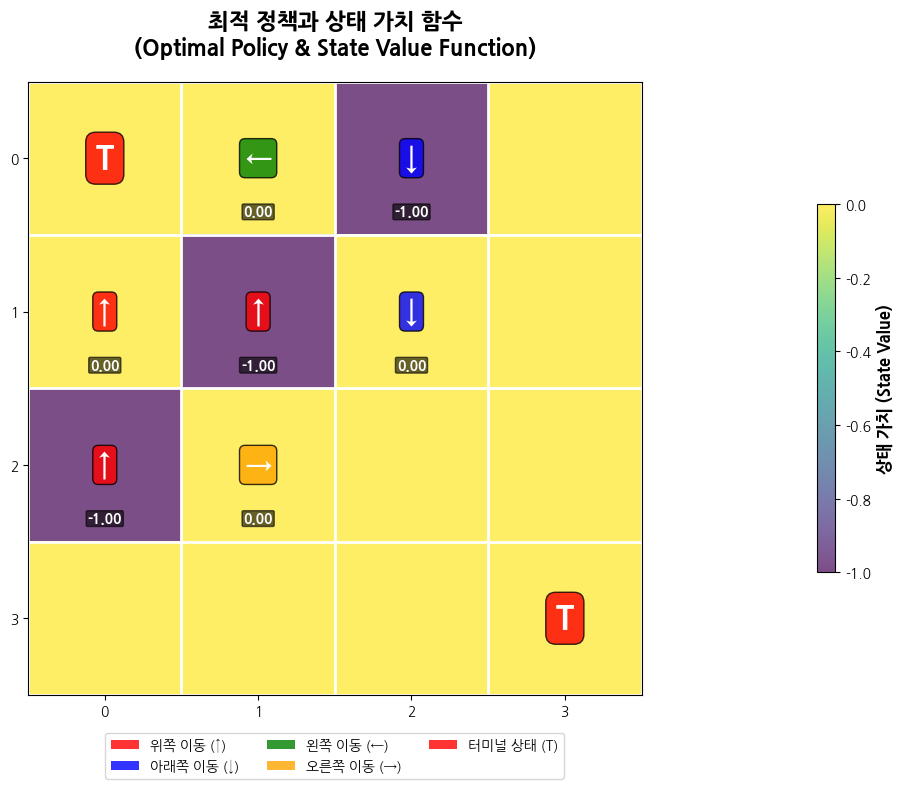

In [ ]:
# ## 정책 반복 (Policy Iteration) 알고리즘
#
# ### 알고리즘 개요:
# 1. 임의의 정책 π로 초기화
# 2. 반복:
#    a. 정책평가: V^π 계산 (현재 정책에 대한 가치 함수 계산)
#    b. 정책개선: π'(s) = argmax_a Σ_s' P(s'|s,a)[R(s,a,s') + γV^π(s')]
#    c. π' = π이면 종료, 아니면 π = π'로 업데이트하고 a단계로 돌아감

# GridWorld 환경 생성
grid_world = GridWorld()

def policy_iteration(mdp, gamma=0.9, theta=1e-6):
    """
    정책 반복 알고리즘을 구현합니다.

    Args:
        mdp: MDP 환경
        gamma: 할인율
        theta: 수렴 판정 임계값

    Returns:
        optimal_policy: 최적 정책
        optimal_V: 최적 가치 함수
        iteration_count: 반복 횟수
    """

    # 1. 임의의 정책 π로 초기화
    print("=== 정책 반복 알고리즘 시작 ===")
    current_policy = {}
    for state in mdp.states:
        if not mdp.is_terminal(state):
            current_policy[state] = mdp.actions[0]

    print("초기 정책 설정 완료")

    iteration_count = 0

    while True:
        iteration_count += 1
        print(f"\n--- 반복 {iteration_count}회차 ---")

        # 2a. 정책평가
        print("정책평가 단계: 현재 정책에 대한 가치 함수 계산 중...")
        current_V = policy_evaluation_for_policy_iteration(mdp, current_policy, gamma, theta)

        # 2b. 정책개선
        print("정책개선 단계: 새로운 정책 계산 중...")
        new_policy = {}
        policy_stable = True

        for state in mdp.states:
            if not mdp.is_terminal(state):
                old_action = current_policy[state]

                action_values = {}
                for action in mdp.actions:
                    action_value = 0
                    next_states = mdp.get_possible_next_states(state, action)
                    for next_state in next_states:
                        prob = mdp.get_transition_probability(state, action, next_state)
                        reward = mdp.get_reward(state, action, next_state)
                        # [TODO] 벨만 방정식을 이용해 행동 가치를 계산하세요
                        action_value += ____
                    action_values[action] = action_value

                # [TODO] 가장 높은 가치를 가지는 행동을 선택하세요
                best_action = ____
                new_policy[state] = best_action

                if old_action != best_action:
                    # [TODO] 정책이 변경되었다면 policy_stable을 False로 설정하세요
                    policy_stable = ____

        # [TODO] 정책이 수렴했는지 확인하고, 수렴했다면 결과를 반환하세요
        if ____:
            print(f"정책이 수렴했습니다! (총 {iteration_count}회 반복)")
            return new_policy, current_V, iteration_count

        current_policy = new_policy
        print("정책이 변경되었습니다. 다음 반복을 진행합니다.")

def policy_evaluation_for_policy_iteration(mdp, policy, gamma=0.9, theta=1e-6):
    """
    주어진 정책에 대한 가치 함수를 계산합니다 (정책 평가).
    """
    # [TODO] 모든 상태의 가치 함수를 0.0으로 초기화하세요
    V = ____

    while True:
        delta = 0
        for state in mdp.states:
            if not mdp.is_terminal(state):
                old_v = V[state]

                # [TODO] 현재 정책에서 해당 상태의 행동을 가져오세요
                action = ____
                new_v = 0
                next_states = mdp.get_possible_next_states(state, action)
                for next_state in next_states:
                    prob = mdp.get_transition_probability(state, action, next_state)
                    reward = mdp.get_reward(state, action, next_state)
                    # [TODO] 벨만 방정식을 이용해 새로운 가치를 계산하세요
                    new_v += ____

                V[state] = new_v
                # [TODO] 가치 함수의 변화량을 계산하세요
                delta = max(delta, ____)

        # [TODO] 수렴 조건을 확인하세요
        if ____:
            break

    return V

# 정책 반복 알고리즘 실행
print("\n" + "="*60)
print("정책 반복 알고리즘 실행")
print("="*60)

gamma = 0.9
theta = 1e-6

optimal_policy_pi, optimal_V_pi, iteration_count_pi = policy_iteration(grid_world, gamma, theta)

print(f"\n=== 정책 반복 결과 ===")
print(f"총 반복 횟수: {iteration_count_pi}회")
print(f"감마(할인율): {gamma}")
print(f"수렴 기준(theta): {theta}")

# 최적 정책 출력
print("\n=== 최적 정책 (Policy Iteration) ===")
for i in range(grid_world.size):
    for j in range(grid_world.size):
        state = (i, j)
        if grid_world.is_terminal(state):
            print("  T  ", end="  ")
        elif state in optimal_policy_pi:
            action = optimal_policy_pi[state]
            action_symbol = {"up": "↑", "down": "↓", "left": "←", "right": "→"}[action]
            print(f"  {action_symbol}  ", end="  ")
        else:
            print("  ?  ", end="  ")
    print()

# 최적 가치 함수 출력
print("\n=== 최적 가치 함수 (Policy Iteration) ===")
for i in range(grid_world.size):
    for j in range(grid_world.size):
        state = (i, j)
        if state in optimal_V_pi:
            print(f"V*({i},{j}) = {optimal_V_pi[state]:.4f}", end="  ")
        else:
            print(f"V*({i},{j}) = 0.0000", end="  ")
    print()

# 정책 반복 결과 시각화
print("\n=== 정책 반복 결과 시각화 ===")
visualize_policy_and_value(optimal_policy_pi, optimal_V_pi)


---

# 가치 반복


=== 가치 반복 결과 ===
총 반복 횟수: 2회
감마(할인율): 0.9
수렴 기준(theta): 1e-06

=== 최적 정책 (Value Iteration) ===
  T      ←      ↓    
  ↑      ↑      ↓    
  ↑      →      T    

=== 최적 가치 함수 (Value Iteration) ===
V*(0,0) = 0.0000  V*(0,1) = 0.0000  V*(0,2) = -1.0000  
V*(1,0) = 0.0000  V*(1,1) = -1.0000  V*(1,2) = 0.0000  
V*(2,0) = -1.0000  V*(2,1) = 0.0000  V*(2,2) = 0.0000  

=== 가치 반복 결과 시각화 ===


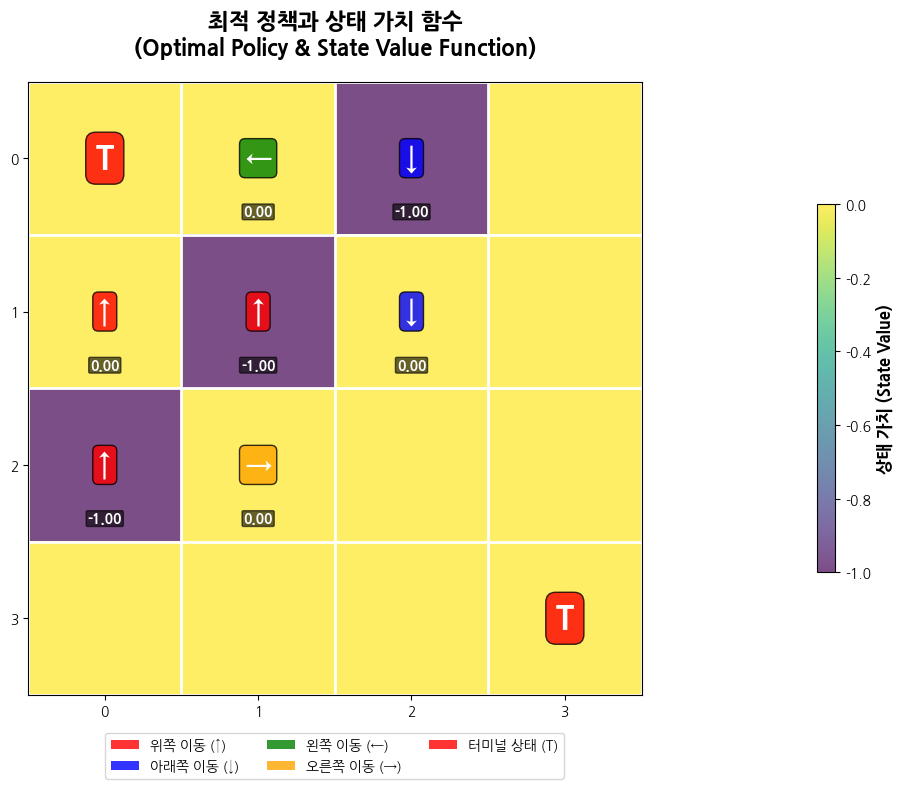

In [ ]:
# 가치 반복 알고리즘 수도코드
# 가치반복 알고리즘 (Value Iteration Algorithm)
# 1. 모든 상태의 가치함수를 0으로 초기화
#    V(s) = 0 for all s ∈ S
#
# 2. 수렴할 때까지 반복:
#    a. Δ = 0 (델타 초기화)
#    b. 모든 상태 s에 대해:
#       i. v = V(s) (현재 상태의 가치 저장)
#       ii. V(s) = max_a Σ_s' P(s'|s,a)[R(s,a,s') + γV(s')] (벨만 최적 방정식)
#       iii. Δ = max(Δ, |v - V(s)|) (델타 갱신)
#    c. Δ < θ이면 종료 (수렴 확인)
#
# 3. 최적 정책 도출:
#    π*(s) = argmax_a Σ_s' P(s'|s,a)[R(s,a,s') + γV(s')]
#    각 상태에서 가장 높은 가치를 가지는 행동 선택

# 가치 반복 알고리즘 구현
def value_iteration(grid_world, gamma, theta):
    # 1. 모든 상태의 가치함수를 0으로 초기화
    V = {state: 0 for state in grid_world.states}
    iteration_count = 0

    while True:
        # 2.a. 델타 초기화
        delta = ____  # [TODO: 델타를 0으로 초기화하세요]
        iteration_count += 1

        # 2.b. 모든 상태에 대해 벨만 최적 방정식을 이용한 가치함수 갱신
        for state in grid_world.states:
            if grid_world.is_terminal(state):
                continue

            # 2.b.i. 현재 상태의 가치 저장
            v = ____  # [TODO: 현재 상태의 가치함수 값을 저장하세요]

            # 2.b.ii. 벨만 최적 방정식을 통한 가치함수 갱신
            values = []
            for action in grid_world.actions:
                value = 0
                next_state = grid_world.get_next_state(state, action)
                prob = grid_world.get_transition_probability(state, action, next_state)
                reward = grid_world.get_reward(state, action, next_state)
                value += ____  # [TODO: 벨만 방정식 prob * (reward + gamma * V[next_state])을 계산하세요]
                values.append(value)

            V[state] = ____  # [TODO: values 리스트에서 최댓값을 선택하세요]

            # 2.b.iii. 델타 갱신
            delta = max(delta, ____) # [TODO: 이전 가치와 새로운 가치의 절댓값 차이를 계산하세요]

        # 2.c. 수렴 확인
        if delta < theta:
            break

    # 3. 최적 정책 도출
    optimal_policy = {}
    for state in grid_world.states:
        if grid_world.is_terminal(state):
            continue

        # 각 행동에 대한 가치를 계산하여 최적의 행동 선택
        best_action = None
        best_value = float('-inf')

        for action in grid_world.actions:
            value = 0
            next_state = grid_world.get_next_state(state, action)
            prob = grid_world.get_transition_probability(state, action, next_state)
            reward = grid_world.get_reward(state, action, next_state)
            value += ____  # [TODO: 벨만 방정식 prob * (reward + gamma * V[next_state])을 계산하세요]

            if value > best_value:
                best_value = value
                best_action = ____  # [TODO: 현재 검토 중인 행동을 저장하세요]

        optimal_policy[state] = best_action

    return optimal_policy, V, iteration_count

# 가치 반복 실행
optimal_policy_v, optimal_V_v, iteration_count_v = value_iteration(grid_world, gamma, theta)

print(f"\n=== 가치 반복 결과 ===")
print(f"총 반복 횟수: {iteration_count_v}회")
print(f"감마(할인율): {gamma}")
print(f"수렴 기준(theta): {theta}")

# 최적 정책 출력
print("\n=== 최적 정책 (Value Iteration) ===")
for i in range(grid_world.size):
    for j in range(grid_world.size):
        state = (i, j)
        if grid_world.is_terminal(state):
            print("  T  ", end="  ")
        elif state in optimal_policy_v:
            action = optimal_policy_v[state]
            action_symbol = {"up": "↑", "down": "↓", "left": "←", "right": "→"}[action]
            print(f"  {action_symbol}  ", end="  ")
        else:
            print("  ?  ", end="  ")
    print()

# 최적 가치 함수 출력
print("\n=== 최적 가치 함수 (Value Iteration) ===")
for i in range(grid_world.size):
    for j in range(grid_world.size):
        state = (i, j)
        if state in optimal_V_v:
            print(f"V*({i},{j}) = {optimal_V_v[state]:.4f}", end="  ")
        else:
            print(f"V*({i},{j}) = 0.0000", end="  ")
    print()

# 가치 반복 결과 시각화
print("\n=== 가치 반복 결과 시각화 ===")
visualize_policy_and_value(optimal_policy_v, optimal_V_v)


---
---

Gym FrozenLake

**FrozenLake 환경 소개**

FrozenLake는 OpenAI Gym에서 제공하는 간단한 그리드 월드 환경입니다.

**환경 설명:**
- 에이전트는 얼어붙은 호수 위를 걸어서 목표지점까지 도달해야 합니다
- 호수 표면은 안전한 얼음(F)과 위험한 구멍(H)으로 구성되어 있습니다
- 구멍에 빠지면 게임이 종료되고 보상을 받지 못합니다
- 목표지점(G)에 도달하면 +1의 보상을 받고 게임이 종료됩니다

**상태 공간:**
- 4x4 또는 8x8 그리드의 각 위치
- 각 상태는 0부터 n-1까지의 정수로 표현됩니다

**행동 공간:**
- LEFT (0): 왼쪽으로 이동
- DOWN (1): 아래로 이동  
- RIGHT (2): 오른쪽으로 이동
- UP (3): 위쪽으로 이동

**보상 구조:**
- 목표 도달: +1
- 구멍에 빠짐: 0
- 일반 이동: 0

**환경 설정:**
- `is_slippery=True`: 미끄러운 환경 (확률적 전이)
- `is_slippery=False`: 미끄럽지 않은 환경 (결정적 전이)


In [ ]:
# FrozenLake 환경을 사용한 모델 기반 강화학습 구현
import gym
import numpy as np
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv

# FrozenLake 환경 생성 (4x4 그리드, 미끄러지지 않는 설정)
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode=None)

print("=== FrozenLake 환경 정보 ===")
print(f"상태 공간 크기: {env.observation_space.n}")
print(f"행동 공간 크기: {env.action_space.n}")
print(f"행동 정의: {['LEFT', 'DOWN', 'RIGHT', 'UP']}")

# 환경 맵 출력
print("\n=== FrozenLake 맵 ===")
print("S: 시작점, F: 얼음(안전), H: 구멍(위험), G: 목표")
env.reset()
env.render()

# FrozenLake용 MDP 클래스 구현
class FrozenLakeMDP:
    def __init__(self, env):
        self.env = env
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        self.states = list(range(self.n_states))
        self.actions = list(range(self.n_actions))

        # 환경의 전이 정보 추출
        self.P = env.P  # 전이 확률 딕셔너리

    def get_transition_probability(self, state, action, next_state):
        """상태 전이 확률 반환"""
        transitions = self.P[state][action]
        for prob, next_s, reward, done in transitions:
            if next_s == next_state:
                return prob
        return 0.0

    def get_reward(self, state, action, next_state):
        """보상 반환"""
        transitions = self.P[state][action]
        for prob, next_s, reward, done in transitions:
            if next_s == next_state:
                return reward
        return 0.0

    def get_possible_next_states(self, state, action):
        """가능한 다음 상태들 반환"""
        transitions = self.P[state][action]
        return [next_state for prob, next_state, reward, done in transitions if prob > 0]

    def is_terminal(self, state):
        """터미널 상태 확인 (구멍이나 목표에 도달)"""
        # FrozenLake에서 H(구멍)이나 G(목표)는 터미널 상태
        desc = self.env.desc.flatten()
        return desc[state] in [b'H', b'G']

# FrozenLake MDP 객체 생성
frozen_mdp = FrozenLakeMDP(env)

# 정책 반복 알고리즘을 FrozenLake에 적용
def policy_iteration_frozen(mdp, gamma=0.9, theta=1e-6):
    """FrozenLake용 정책 반복 알고리즘"""
    # 1. 임의의 정책으로 초기화 (모든 상태에서 행동 0 선택)
    policy = {state: 0 for state in mdp.states if not mdp.is_terminal(state)}

    iteration_count = 0

    while True:
        iteration_count += 1

        # 정책 평가
        V = policy_evaluation_frozen(mdp, policy, gamma, theta)

        # 정책 개선
        policy_stable = True

        for state in mdp.states:
            if not mdp.is_terminal(state):
                old_action = policy[state]

                # 각 행동에 대한 가치 계산
                action_values = []
                for action in mdp.actions:
                    action_value = 0
                    next_states = mdp.get_possible_next_states(state, action)
                    for next_state in next_states:
                        prob = mdp.get_transition_probability(state, action, next_state)
                        reward = mdp.get_reward(state, action, next_state)
                        action_value += prob * (reward + gamma * V[next_state])
                    action_values.append(action_value)

                # TODO: 가장 높은 가치를 가진 행동을 선택하여 정책 업데이트
                policy[state] = ____

                if old_action != policy[state]:
                    policy_stable = False

        # TODO: 정책이 안정화되었으면 반복 종료
        if ____:
            break

    return policy, V, iteration_count

def policy_evaluation_frozen(mdp, policy, gamma=0.9, theta=1e-6):
    """FrozenLake용 정책 평가"""
    # TODO: 모든 상태의 가치함수를 0.0으로 초기화
    V = ____

    while True:
        delta = 0
        for state in mdp.states:
            if not mdp.is_terminal(state):
                old_v = V[state]

                # TODO: 현재 정책에서 선택된 행동을 가져오기
                action = ____
                new_v = 0
                next_states = mdp.get_possible_next_states(state, action)
                for next_state in next_states:
                    prob = mdp.get_transition_probability(state, action, next_state)
                    reward = mdp.get_reward(state, action, next_state)
                    # TODO: 벨만 방정식을 사용하여 새로운 가치 계산
                    new_v += ____

                V[state] = new_v
                delta = max(delta, abs(old_v - new_v))

        # TODO: 델타가 임계값보다 작으면 수렴으로 판단하고 종료
        if ____:
            break

    return V

# 가치 반복 알고리즘을 FrozenLake에 적용
def value_iteration_frozen(mdp, gamma=0.9, theta=1e-6):
    """FrozenLake용 가치 반복 알고리즘"""
    # TODO: 모든 상태의 가치함수를 0.0으로 초기화
    V = ____

    iteration_count = 0

    # 2. 수렴할 때까지 반복
    while True:
        iteration_count += 1
        delta = 0

        for state in mdp.states:
            if not mdp.is_terminal(state):
                old_v = V[state]

                # TODO: 모든 행동에 대한 가치를 계산하고 action_values 리스트에 저장
                action_values = []
                for action in mdp.actions:
                    action_value = 0
                    next_states = mdp.get_possible_next_states(state, action)
                    for next_state in next_states:
                        prob = mdp.get_transition_probability(state, action, next_state)
                        reward = mdp.get_reward(state, action, next_state)
                        # TODO: 벨만 방정식을 사용하여 action_value 계산
                        action_value += ____
                    action_values.append(action_value)

                # TODO: 최대 가치를 현재 상태의 새로운 가치로 설정
                V[state] = ____
                delta = max(delta, abs(old_v - V[state]))

        # TODO: 델타가 임계값보다 작으면 수렴으로 판단하고 종료
        if ____:
            break

    # 3. 최적 정책 도출
    policy = {}
    for state in mdp.states:
        if not mdp.is_terminal(state):
            action_values = []
            for action in mdp.actions:
                action_value = 0
                next_states = mdp.get_possible_next_states(state, action)
                for next_state in next_states:
                    prob = mdp.get_transition_probability(state, action, next_state)
                    reward = mdp.get_reward(state, action, next_state)
                    action_value += prob * (reward + gamma * V[next_state])
                action_values.append(action_value)

            # TODO: 가장 높은 가치를 가진 행동을 최적 정책으로 선택
            policy[state] = ____

    return policy, V, iteration_count

# FrozenLake에서 정책 반복과 가치 반복 실행
print("\n" + "="*60)
print("FrozenLake에서 동적 계획법 실행")
print("="*60)

gamma = 0.9
theta = 1e-6

# 정책 반복 실행
print("\n=== 정책 반복 실행 중... ===")
# TODO: 정책 반복 함수를 호출하여 최적 정책과 가치함수, 반복 횟수를 구하기
policy_pi, V_pi, iter_pi = ____

# 가치 반복 실행
print("=== 가치 반복 실행 중... ===")
# TODO: 가치 반복 함수를 호출하여 최적 정책과 가치함수, 반복 횟수를 구하기
policy_vi, V_vi, iter_vi = ____

# 결과 출력 함수
def print_frozen_results(policy, V, method_name, iterations):
    """FrozenLake 결과 출력 함수"""
    print(f"\n=== {method_name} 결과 ===")
    print(f"총 반복 횟수: {iterations}회")
    print(f"감마(할인율): {gamma}")
    print(f"수렴 기준(theta): {theta}")

    # 정책을 4x4 그리드로 시각화
    action_symbols = ['←', '↓', '→', '↑']
    print(f"\n=== 최적 정책 ({method_name}) ===")
    desc = env.desc

    for i in range(4):
        for j in range(4):
            state = i * 4 + j
            cell_type = desc[i][j].decode('utf-8')

            if cell_type in ['H', 'G']:  # 터미널 상태
                print(f"  {cell_type}  ", end="  ")
            elif state in policy:
                action = policy[state]
                symbol = action_symbols[action]
                print(f"  {symbol}  ", end="  ")
            else:
                print(f"  ?  ", end="  ")
        print()

    # 가치 함수 출력
    print(f"\n=== 가치 함수 ({method_name}) ===")
    for i in range(4):
        for j in range(4):
            state = i * 4 + j
            if state in V:
                print(f"{V[state]:6.3f}", end="  ")
            else:
                print(f" 0.000", end="  ")
        print()

# 결과 출력
print_frozen_results(policy_pi, V_pi, "정책 반복", iter_pi)
print_frozen_results(policy_vi, V_vi, "가치 반복", iter_vi)

# 두 방법 비교
print("\n" + "="*60)
print("GridWorld vs FrozenLake 비교 분석")
print("="*60)

print(f"\n=== 수렴 속도 비교 ===")
print(f"정책 반복 - GridWorld: {iteration_count_pi}회, FrozenLake: {iter_pi}회")
print(f"가치 반복 - GridWorld: {iteration_count_v}회, FrozenLake: {iter_vi}회")

print(f"\n=== 정책 일치도 확인 ===")
# 정책 반복과 가치 반복이 같은 정책을 찾았는지 확인
policies_match = all(policy_pi.get(s) == policy_vi.get(s) for s in range(16) if not frozen_mdp.is_terminal(s))
print(f"FrozenLake에서 정책 반복과 가치 반복 결과 일치: {policies_match}")

print(f"\n=== 환경별 특성 ===")
print("GridWorld (3x3):")
print("- 상태 수: 9개")
print("- 터미널 상태: 2개 (시작점, 목표점)")
print("- 보상 구조: 모든 전이에서 -1 (목표 지향적)")

print("\nFrozenLake (4x4):")
print("- 상태 수: 16개")
print("- 터미널 상태: 구멍(H) + 목표(G)")
print("- 보상 구조: 목표 도달시에만 +1 (희소 보상)")

env.close()


=== FrozenLake 환경 정보 ===
상태 공간 크기: 16
행동 공간 크기: 4
행동 정의: ['LEFT', 'DOWN', 'RIGHT', 'UP']

=== FrozenLake 맵 ===
S: 시작점, F: 얼음(안전), H: 구멍(위험), G: 목표

FrozenLake에서 동적 계획법 실행

=== 정책 반복 실행 중... ===
=== 가치 반복 실행 중... ===

=== 정책 반복 결과 ===
총 반복 횟수: 7회
감마(할인율): 0.9
수렴 기준(theta): 1e-06

=== 최적 정책 (정책 반복) ===
  ↓      →      ↓      ←    
  ↓      H      ↓      H    
  →      ↓      ↓      H    
  H      →      →      G    

=== 가치 함수 (정책 반복) ===
 0.590   0.656   0.729   0.656  
 0.656   0.000   0.810   0.000  
 0.729   0.810   0.900   0.000  
 0.000   0.900   1.000   0.000  

=== 가치 반복 결과 ===
총 반복 횟수: 7회
감마(할인율): 0.9
수렴 기준(theta): 1e-06

=== 최적 정책 (가치 반복) ===
  ↓      →      ↓      ←    
  ↓      H      ↓      H    
  →      ↓      ↓      H    
  H      →      →      G    

=== 가치 함수 (가치 반복) ===
 0.590   0.656   0.729   0.656  
 0.656   0.000   0.810   0.000  
 0.729   0.810   0.900   0.000  
 0.000   0.900   1.000   0.000  

GridWorld vs FrozenLake 비교 분석

=== 수렴 속도 비교 ===
정책 반복 - GridWorld: 3회

/opt/anaconda3/lib/python3.12/site-packages/gym/envs/toy_text/frozen_lake.py:271: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("FrozenLake-v1", render_mode="rgb_array")
  logger.warn(
